<a href="https://colab.research.google.com/github/szsavery/DSPS_SSavery/blob/main/Labs/DSPS2023_autoencoders_8dec23_Savery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from copy import deepcopy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.signal import convolve2d

from tensorflow import keras
from keras.datasets import mnist
from keras import layers

!pip install icecream
from icecream import ic

rng = np.random.RandomState(1415)

# Load MNIST data

In [2]:
# Load the data and split it between train and test sets
(Xtrn, Ytrn), (Xtst, Ytst) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# Visualize dataset

In [4]:
Xtrn.shape, Xtst.shape, Ytrn.shape, Ytst.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [5]:
np.unique(Ytrn)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
def plot_images(images, labels, nrows = 5, ncols = 5, vmin = 0, vmax = 255):
  fig, axes = plt.subplots(nrows, ncols, sharex = True, sharey = True, figsize = (8,8))

  for i in range(nrows*ncols):
    ax = axes.flatten()[i]
    image = images[i]
    label = labels[i]

    ax.set_title(label)
    ax.imshow(image, vmin = vmin, vmax = vmax, cmap = 'Greys')
    ax.set_aspect('equal')
    ax.axis('off')

  fig.tight_layout()
  fig.show()

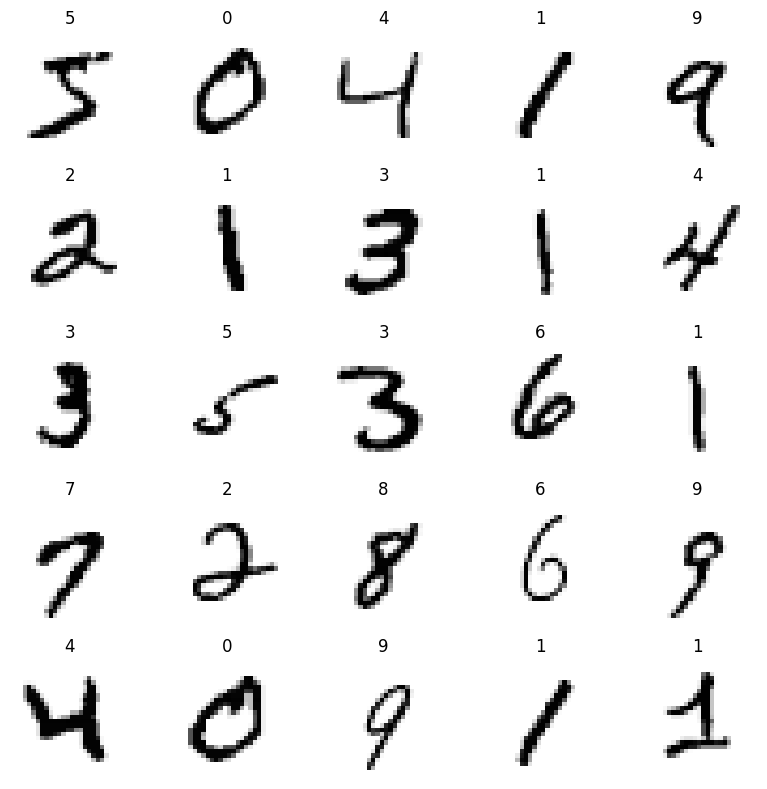

In [9]:
plot_images(Xtrn, Ytrn)

# Normalize the images

In [10]:
def normalize_255(array):
  normed_array = array / 255
  return normed_array


XtrnN = normalize_255(Xtrn)
XtstN = normalize_255(Xtst)

In [11]:
XtrnN.max(), XtstN.max()

(1.0, 1.0)

# Reshape the arrays for Keras

In [12]:
def reshape_for_keras(array):
  reshaped_array = array[..., None]
  return reshaped_array

In [13]:
XtrnNR = reshape_for_keras(XtrnN)
XtstNR = reshape_for_keras(XtstN)

In [14]:
XtrnNR.shape

(60000, 28, 28, 1)

# But wait we don't need the image labels...

### The training set will be the images at half resolution, and the model will try to up-sample the images to the original resolution... `Xtrn` should be the same 60,000 images at half resolution, but `Ytrn` should be those same images at the original resolution. We will do the same operations for the testing set.

# Construct dataset for superresolution, not image classification

In [15]:
def superresolution(X):
  Xnew = deepcopy(X)[:, ::2, ::2,:]
  Ynew = deepcopy(X)

  return Xnew, Ynew


XtrnSR, YtrnSR = superresolution(XtrnNR)
XtstSR, YtstSR = superresolution(XtstNR)

In [17]:
XtrnSR.shape, YtrnSR.shape

((60000, 14, 14, 1), (60000, 28, 28, 1))

# Visualize the new dataset

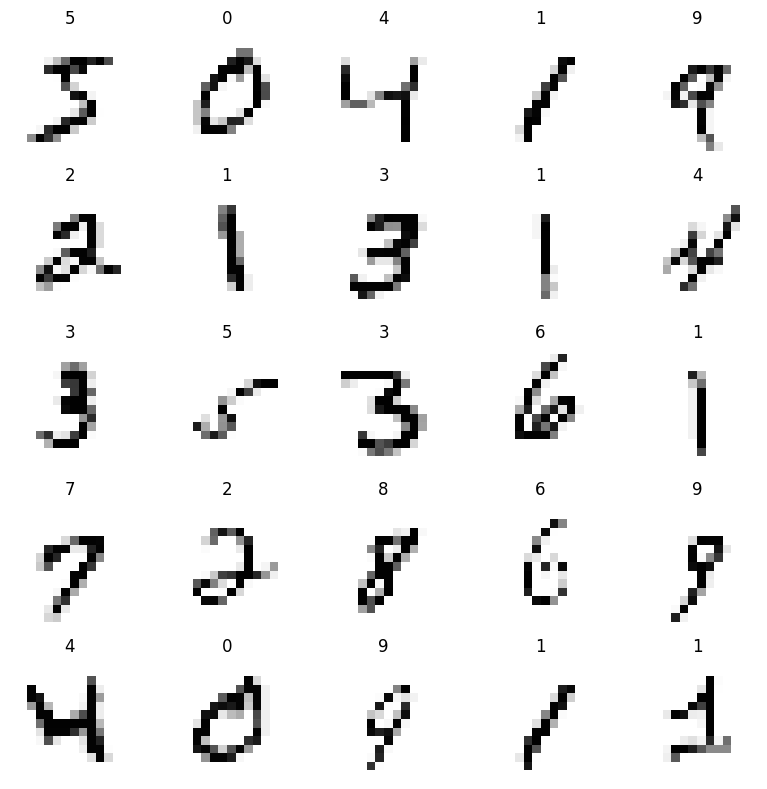

In [20]:
plot_images(XtrnSR[:,:,:,0], Ytrn, vmax = 1)

# Build the CNN autoencoder

In [22]:
def build_cnn_autoencoder(input_shape):

  inputs = layers.Input(shape = input_shape)
  #The encoder
  x = layers.Conv2D(16, kernel_size= (3,3), padding = 'same', activation = 'relu')(inputs)
  x = layers.Conv2D(8, kernel_size= (3,3), padding = 'same', activation = 'relu')(x)
  x = layers.Conv2D(4, kernel_size= (3,3), padding = 'same', activation = 'relu')(x)
  x = layers.MaxPooling2D(pool_size= (2,2))(x)

  shape = x.shape
  num_neurons = shape[1]*shape[2]*shape[3]

  #latent shape
  x = layers.Flatten()(x)
  LS = layers.Dense(16,activation='relu')(x)
  x = layers.Dense(num_neurons, activation='relu')(LS)
  x = layers.Reshape(shape[1:])(x)

  #The decoder
  x = layers.Conv2DTranspose(4, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.Conv2DTranspose(8, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.UpSampling2D(size = (2,2))(x)

  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.UpSampling2D(size = (2,2))(x)

  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'sigmoid')(x)
  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'sigmoid')(x)
  outputs = layers.Conv2DTranspose(1, kernel_size= (3,3), padding = 'same', activation= 'sigmoid')(x)

  model = keras.Model(inputs, outputs)

  encoder = keras.Model(inputs, LS)
  decoder = keras.Model(LS, outputs)

  return model, encoder, decoder

input_shape = XtrnSR.shape[1:]
model, encoder, decoder = build_cnn_autoencoder(input_shape)
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 4)           0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 196)               0         
                                                           

# Train the model (use a GPU)

In [23]:
model.compile(loss = 'mse', optimizer= 'adam')
history = model.fit(XtrnSR, YtrnSR, batch_size = 256, epochs = 15, validation_split= 0.1)

Epoch 1/15
211/211 [==============================] - 19s 17ms/step - loss: 0.0837 - val_loss: 0.0524
Epoch 2/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0453 - val_loss: 0.0380
Epoch 3/15
211/211 [==============================] - 3s 12ms/step - loss: 0.0329 - val_loss: 0.0288
Epoch 4/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0273 - val_loss: 0.0260
Epoch 5/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0248 - val_loss: 0.0239
Epoch 6/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 7/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0224 - val_loss: 0.0219
Epoch 8/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0215 - val_loss: 0.0209
Epoch 9/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0210 - val_loss: 0.0205
Epoch 10/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0204 - val_l

# Visualize the predictions

In [24]:
PtstSR = model.predict(XtstSR)
PtstSR.shape

313/313 [==============================] - 1s 3ms/step


(10000, 28, 28, 1)

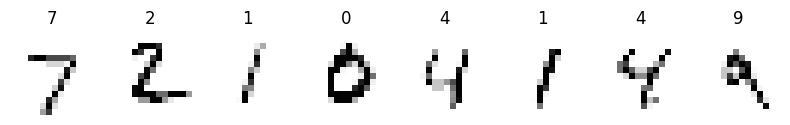

In [26]:
plot_images(XtstSR[:,:,:,0], Ytst, nrows = 1, ncols = 8, vmax = 1)

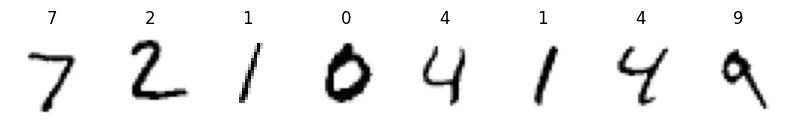

In [28]:
plot_images(YtstSR[:,:,:,0], Ytst, nrows = 1, ncols = 8, vmax = 1)

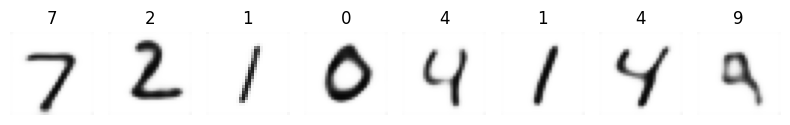

In [27]:
plot_images(PtstSR[:,:,:,0], Ytst, nrows = 1, ncols = 8, vmax = 1)

# Visualize loss curve

# Visualize the early layers

In [32]:
model.layers[1].get_weights()[0].shape

(3, 3, 1, 16)

# Visualize the latent space with the encoder and decoder on their own

In [33]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 4)           0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 196)               0         
                                                           

In [34]:
LS = encoder.predict(XtstSR)
ic(LS.shape)

LS_images = LS.reshape((10_000,4,4))

313/313 [==============================] - 1s 2ms/step


ic| LS.shape: (10000, 16)


In [ ]:
output = decoder.predict(LS)

# Find the average latent space representation for each digit

# Decode latent space representations with the decoder

# What if we input something in the latent space by hand and then decode it?